In [25]:
from scipy.sparse import SparseEfficiencyWarning
from math import sqrt
from typing import Literal
import warnings

from matplotlib import pyplot as plt
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sp_linalg
from numpy import ndarray
from scipy.sparse import csc_matrix

warnings.simplefilter("ignore", SparseEfficiencyWarning)


def process_stencil(stencil: ndarray, center: tuple[float, ...], grid_shape: tuple[int, ...]) -> tuple[ndarray, ndarray]:
    offsets_x = np.arange(stencil.shape[1]) - (stencil.shape[1] - 1) / 2 + center[0]
    offsets_y = np.arange(stencil.shape[0]) - (stencil.shape[0] - 1) / 2 + center[1]
    offsets = offsets_x[np.newaxis, :] + grid_shape[0] * offsets_y[:, np.newaxis]

    assert offsets.shape == stencil.shape

    stencil_offsets = np.ravel(offsets)
    stencil_values = np.ravel(stencil)

    important_indices = (stencil_values != 0)

    stencil_offsets = stencil_offsets[important_indices]
    stencil_values = stencil_values[important_indices]
    return (stencil_offsets, stencil_values)


def sparse(i: ndarray, j: ndarray, v: ndarray, m: int, n: int) -> csc_matrix:
    i = np.ravel(i)
    j = np.ravel(j)
    v = np.ravel(v)
    return sp.csc_matrix((v, (i, j)), shape=(m, n))


# Reference: [Chladni Figures and the Tacoma Bridge: Motivating PDE Eigenvalue Problems via Vibrating Plates] by [Martin J. Gander and Felix Kwok]
def biharmonic_operator(n: int, mu: float) -> tuple[csc_matrix, csc_matrix]:
    # The size of matrices including ghost points is denoted by m.
    m = n + 2

    # Define the discrete laplacian matrices for 1D and 2D.
    # These are not scaled by 1/h^2.
    identity_1D = sp.eye(m, format="csc")
    assert isinstance(identity_1D, csc_matrix)
    identity_1D[[0, -1], :] = 0

    laplacian_1D = sp.spdiags(np.asarray([1, -2, 1])[:, np.newaxis] * np.ones(m), [-1, 0, 1], m, m, format="csc")
    assert isinstance(laplacian_1D, csc_matrix)
    laplacian_1D[[0, -1], :] = 0

    laplacian_2D = sp.kron(identity_1D, laplacian_1D, format="csc") + sp.kron(laplacian_1D, identity_1D, format="csc")
    assert isinstance(laplacian_2D, csc_matrix)

    fidx_grid = np.reshape(np.arange(m**2), newshape=(m, m))

    edge_left = fidx_grid[1:- 1, 1]
    edge_right = fidx_grid[1:- 1, - 2]
    edge_top = fidx_grid[-2, 1:- 1]
    edge_bottom = fidx_grid[1, 1: - 1]

    ghost_left = fidx_grid[1:- 1, 0]
    ghost_right = fidx_grid[1:- 1, - 1]
    ghost_top = fidx_grid[-1, 1:- 1]
    ghost_bottom = fidx_grid[0, 1: - 1]

    domain = np.ravel(fidx_grid[1: - 1, 1: - 1])
    ghost = np.concatenate([ghost_left, ghost_right, ghost_top, ghost_bottom])

    # N is the finite volume discretization of the negative laplacian to be applied to w, given by:
    # (Nw)_(ij) = integral of -laplacian w over V_(ij) = integral of -dw/dn over the boundary of V_(ij).
    #
    # The input vector w includes ghost points. The output vector Nw does not include ghost points.
    # The ghost points of w correspond to special boundary integrals (3.10 and following / 3.12 and following) and can be eliminated with finite differences.
    #
    # The interior stencil coincides with the five point stencil (3.9).
    # The coefficients of the edge stencils along the edges need to be halved (3.10).
    # The coefficients of the corner stencils along the edges need to be halved, and the coefficients of the corners themselves need to be quartered (3.12).
    # Therefore, it is enough to adjust all edge stencils. This way, the corner coefficients will be adjusted twice, which is exactly what we want.
    N = -laplacian_2D.copy()
    N[edge_left[:, np.newaxis], edge_left[np.newaxis, :]] /= 2
    N[edge_right[:, np.newaxis], edge_right[np.newaxis, :]] /= 2
    N[edge_top[:, np.newaxis], edge_top[np.newaxis, :]] /= 2
    N[edge_bottom[:, np.newaxis], edge_bottom[np.newaxis, :]] /= 2
    assert isinstance(N, csc_matrix)

    # Helper function for constructing L.
    def one_side_of_L(orientation: Literal["horizontal"] | Literal["vertical"], ghost_fidx: ndarray, boundary_fidx: ndarray) -> csc_matrix:
        match orientation:
            case "horizontal":
                stencil = 1 / 2 * np.asarray([[1, 0, -1],
                                              [-1, 0, 1]])
                center_plus = (0, 1 / 2)
                center_minus = (0, -1 / 2)
            case "vertical":
                stencil = 1 / 2 * np.asarray([[1, -1],
                                              [0, 0],
                                              [-1, 1]])
                center_plus = (1 / 2, 0)
                center_minus = (-1 / 2, 0)

        (stencil_offsets_plus, stencil_values_plus) = process_stencil(
            stencil=stencil,
            center=center_plus,
            grid_shape=(m, m))

        (stencil_offsets_minus, stencil_values_minus) = process_stencil(
            stencil=stencil,
            center=center_minus,
            grid_shape=(m, m))

        # At the edges, both terms appear (3.10 and following).
        # At the corners, only one term appears (3.12 and following).
        i_plus = ghost_fidx[:-1, np.newaxis]
        i_minus = ghost_fidx[1:, np.newaxis]

        j_plus = boundary_fidx[:-1, np.newaxis] + stencil_offsets_plus
        j_minus = boundary_fidx[1:, np.newaxis] + stencil_offsets_minus

        v_plus = stencil_values_plus
        v_minus = stencil_values_minus

        (i_plus, j_plus, v_plus, i_minus, j_minus, v_minus) = np.broadcast_arrays(i_plus, j_plus, v_plus, i_minus, j_minus, v_minus)

        return -(1 - mu) * (sparse(i_plus, j_plus, v_plus, m ** 2, m ** 2) - sparse(i_minus, j_minus, v_minus, m ** 2, m ** 2))  # type: ignore

    # L is the finite difference discretization of the negative laplacian to be applied to u, given by:
    # (Lu)_(ij) = (-laplacian u)_(ij) = w_(ij)
    #
    # The output vector w = Lu includes ghost points. The input vector u does not include ghost points.
    # The ghost points of w will be constructed from u with finite differences.
    #
    # The interior stencil is the usual five point stencil (3.7).
    # The edge stencils and corner stencils are given by (3.10 and following / 3.12 and following).
    # Note that left/right and top/bottom need alternating signs because the boundary integral of the finite
    # volume discretization keeps its orientation - if its "up" on the left side, then its "down" on the right side.
    L = (-laplacian_2D.copy()
         + one_side_of_L("horizontal", ghost_left, edge_left)
         - one_side_of_L("horizontal", ghost_right, edge_right)
         - one_side_of_L("vertical", ghost_top, edge_top)  # TODO why does it have to be like this exactly?
         + one_side_of_L("vertical", ghost_bottom, edge_bottom))
    assert isinstance(L, csc_matrix)

    # Helper function for constructing A.
    def one_side_of_A(orientation: Literal["horizontal"] | Literal["vertical"], ghost_fidx: ndarray, boundary_fidx: ndarray) -> csc_matrix:
        match orientation:
            case "horizontal":
                stencil = np.asarray([[0, -mu, 0],
                                      [-1, 2 * (1 + mu), -1],
                                      [0, -mu, 0]])
                center = (0, 0)
            case "vertical":
                stencil = np.asarray([[0, -1, 0],
                                      [-mu, 2 * (1 + mu), -mu],
                                      [0, -1, 0]])
                center = (0, 0)

        (stencil_offsets, stencil_values) = process_stencil(
            stencil=stencil,
            center=center,
            grid_shape=(m, m))

        i = ghost_fidx[:, np.newaxis]
        j = boundary_fidx[:, np.newaxis] + stencil_offsets
        v = stencil_values

        (j, v, i) = np.broadcast_arrays(j, v, i)

        return sparse(i, j, v, m ** 2, m ** 2)

    # TODO explanation needed
    A = (N @ L
         + one_side_of_A("horizontal", ghost_left, edge_left)
         + one_side_of_A("horizontal", ghost_right, edge_right)
         + one_side_of_A("vertical", ghost_top, edge_top)
         + one_side_of_A("vertical", ghost_bottom, edge_bottom))
    assert isinstance(A, csc_matrix)

    # TODO explanation needed
    A = A[domain, :][:, domain] - A[domain, :][:, ghost] @ sp_linalg.inv(A[ghost, :][:, ghost]) @ A[ghost, :][:, domain]
    assert isinstance(A, csc_matrix)

    # TODO explanation needed
    B = sp.eye(m**2, format="csc")
    assert isinstance(B, csc_matrix)

    B[edge_left[:, np.newaxis], edge_left[np.newaxis, :]] /= 2
    B[edge_right[:, np.newaxis], edge_right[np.newaxis, :]] /= 2
    B[edge_top[:, np.newaxis], edge_top[np.newaxis, :]] /= 2
    B[edge_bottom[:, np.newaxis], edge_bottom[np.newaxis, :]] /= 2
    B = B[domain, :][:, domain]
    assert isinstance(B, csc_matrix)

    # TODO explanation needed
    h = 2 / (n - 1)
    A = 1 / (h**2) * A
    B = (h**2) * B

    return (A, B)


def calculate_patterns(grid_size: int, mu: float, n_patterns: int) -> tuple[ndarray, ndarray]:  # TODO explanation needed
    (A, B) = biharmonic_operator(grid_size, mu)

    (eigenvalues, eigenfunctions) = sp_linalg.eigs(A=A, M=B, which="SM", k=n_patterns + 5)  # type: ignore
    assert isinstance(eigenvalues, ndarray)
    assert isinstance(eigenfunctions, ndarray)

    eigenfunctions = eigenfunctions.T

    # assert np.all(np.imag(eigenvalues) == 0)  # TODO why can we not assert this
    eigenvalues = np.real(eigenvalues)

    # assert np.all(np.imag(eigenfunctions) == 0)  # TODO why can we not assert this
    eigenfunctions = np.real(eigenfunctions)

    permutation = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[permutation]
    eigenfunctions = eigenfunctions[permutation]

    first_valid_index = np.argmax(eigenvalues > 1)
    assert first_valid_index < 5

    eigenvalues = eigenvalues[first_valid_index:][:n_patterns]
    eigenfunctions = eigenfunctions[first_valid_index:][:n_patterns]

    return (eigenvalues, eigenfunctions)


def show_eigenfunctions(R: int, n_patterns: int) -> None:
    grid_size = 50
    mu = 0.2
    (eigenvalues, eigenfunctions) = calculate_patterns(grid_size, mu, n_patterns)
    plt.figure(figsize=(30, 30))
    for index in range(n_patterns):
        plt.subplot(round(sqrt(n_patterns)) + 1, round(sqrt(n_patterns)) + 1, index + 1)
        plt.title(f"Eigenfrequenz = {R * sqrt(eigenvalues[index]):.2f}")
        plt.contour(np.reshape(eigenfunctions[index], newshape=(grid_size, grid_size)), (-1e-10, +1e-10))
    plt.show()

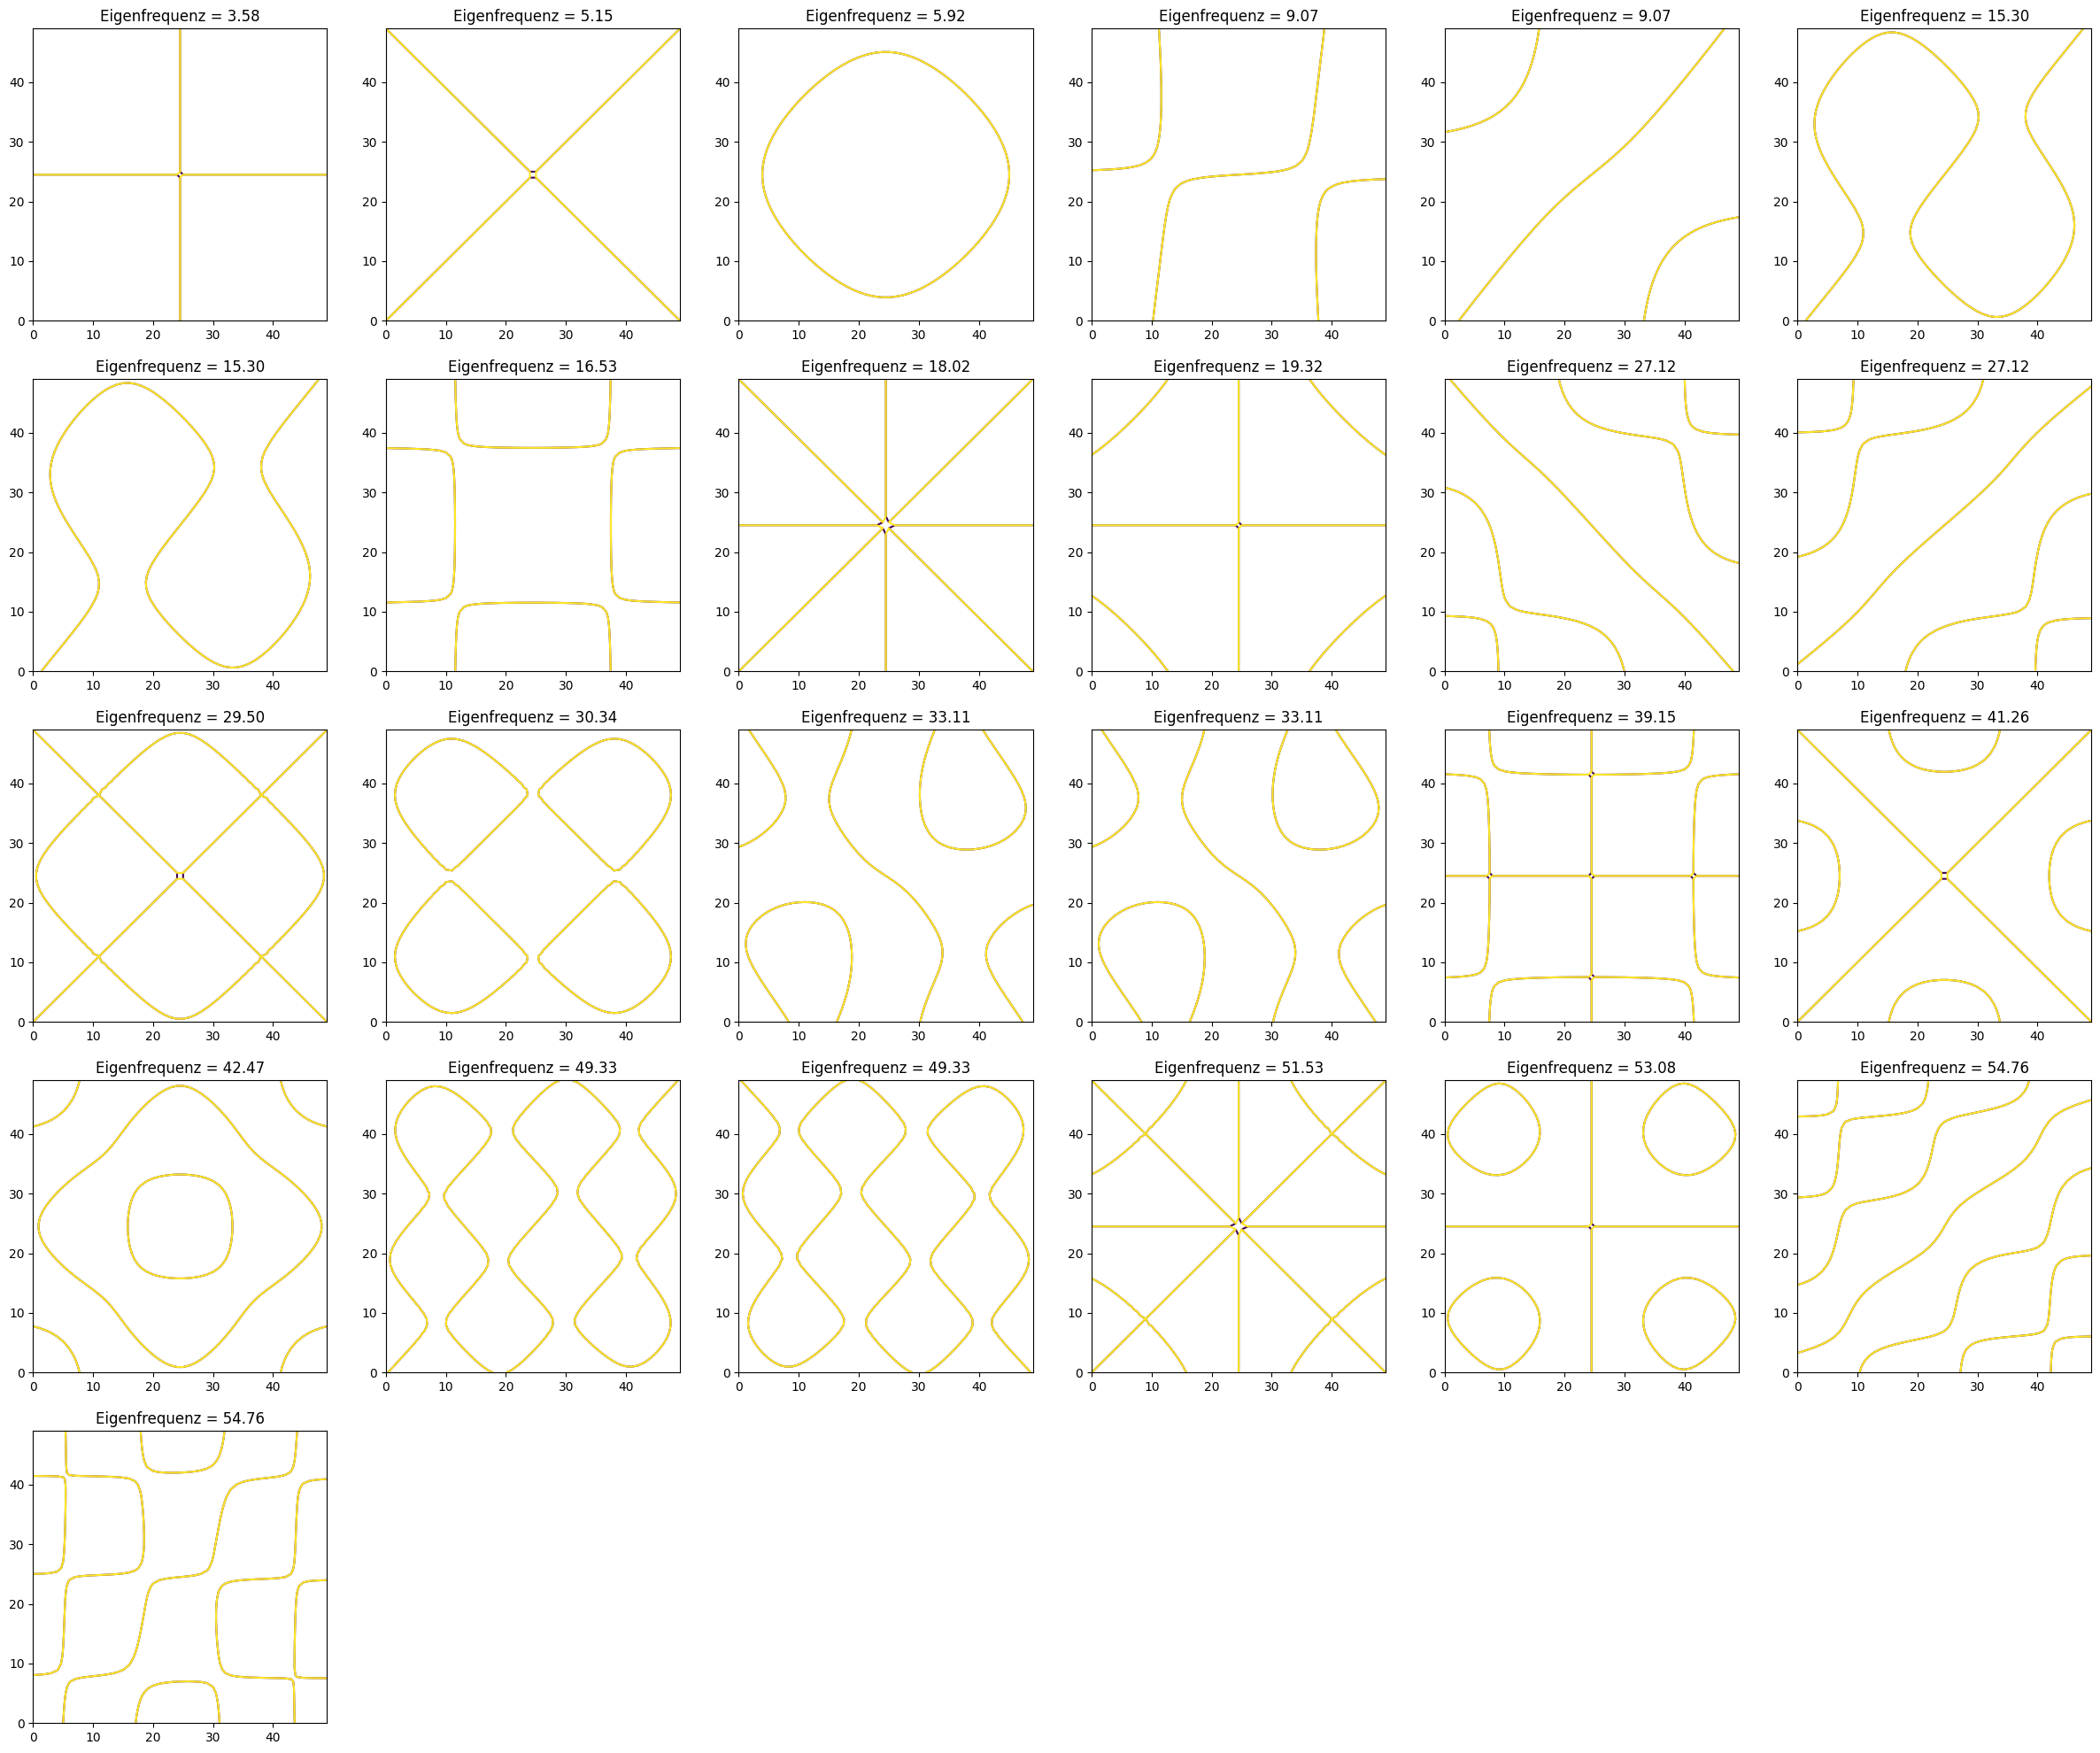

In [26]:
R = 1
n_patterns = 25
show_eigenfunctions(R, n_patterns)